# IFT870 - TP1: Exploration de données

- Gabriel Gibeau Sanchez (GIBG2501)

- Mathieu Lussier (LUSM1202)

In [1]:
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as sdist

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

In [3]:
df = pd.read_csv("TP1_data.csv", index_col=0)

In [4]:
df.head()

,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0


In [5]:
df.describe()

,attribut1,attribut2,attribut3,attribut4,classe
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,49.793220,23.486441,9.594915,14.557627,0.915254
std,10.490782,3.531995,8.174992,4.057994,0.815542
min,28.700000,16.500000,0.000000,3.700000,0.000000
25%,40.850000,21.050000,2.400000,12.000000,0.000000
50%,49.000000,23.300000,9.000000,15.100000,1.000000
75%,59.200000,25.100000,13.000000,16.950000,2.000000
max,68.500000,33.000000,29.100000,23.000000,2.000000


In [6]:
X = df[['attribut1', 'attribut2', 'attribut3', 'attribut4']]
target = df['classe'].values
classes = np.unique(target)

df_c0 = df[df.classe==0].drop("classe", axis=1)
df_c1 = df[df.classe==1].drop("classe", axis=1)
df_c2 = df[df.classe==2].drop("classe", axis=1)

# 1. Représentation des données:

### Visualisation

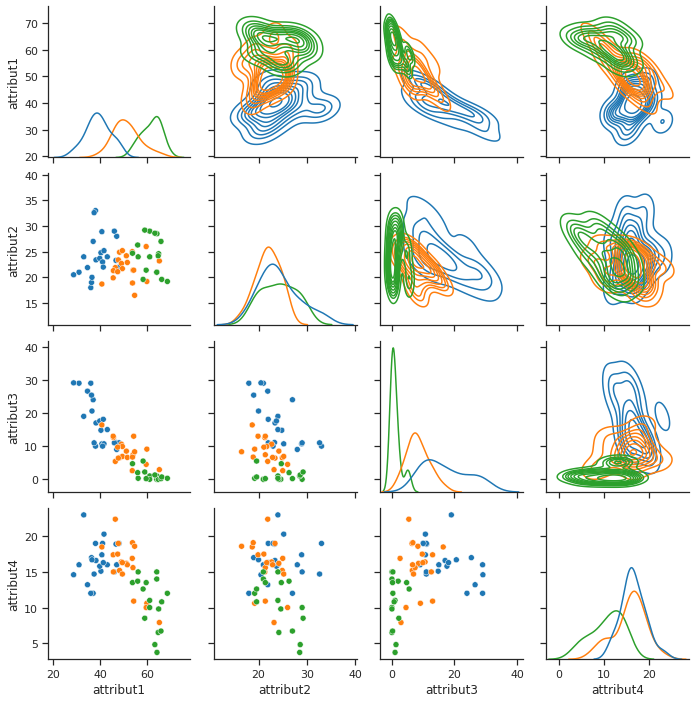

In [7]:
sns.set(style="ticks")

graph = sns.PairGrid(df, hue="classe", palette="tab10")
graph.map_lower(sns.scatterplot)
graph.map_upper(sns.kdeplot)
graph.map_diag(sns.kdeplot)

Nous remarquons que l'**attribut4** ne présente pratiquement aucune de distinction lorsque celui-ci est jumelé avec l'un des trois autres attributs. Ceci est distinctif autant en visualisant les _scatter plots_ que les _kde plots_.

### T-SNE Visualisation

Text(0, 0.5, 'tsne axe 2')

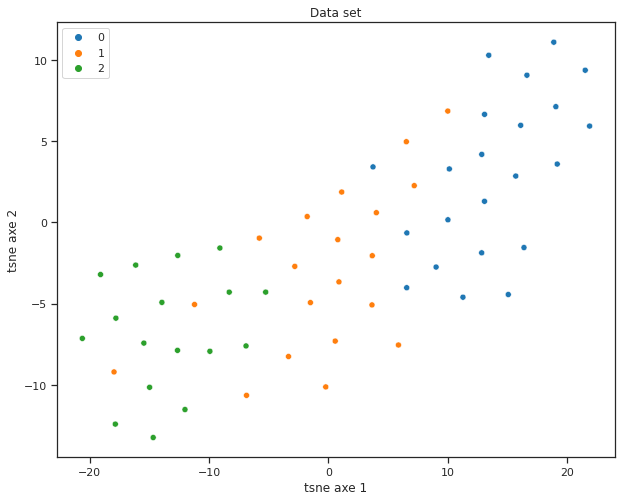

In [8]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

fig, axes = plt.subplots(1, 1,figsize=(10,8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=target, palette='tab10')
axes.set_title('Data set')
axes.set_xlabel("tsne axe 1")
axes.set_ylabel("tsne axe 2")

**T-SNE**: Bien que la division ne soit pas franche, nous pouvons discerner trois niveaux de couleurs différentes représentant les trois classes. Ceci pourrait suggérer que seulement deux attributs contiennent la majorité de l'information.

### Corrélation

<AxesSubplot:>

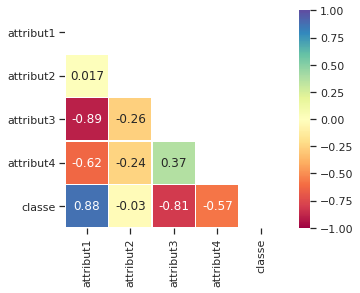

In [9]:
corr_df = df.corr(method='pearson')
corr_c0_df = df_c0.corr(method='pearson')
corr_c1_df = df_c1.corr(method='pearson')
corr_c2_df = df_c2.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap='Spectral', vmax=1, vmin=-1, center=0, annot=True,
            square=True, linewidths=.5)


Nous remarquons que l'**attribut1** & l'**attribut3** présente une forte corrélation négative entre-eux. De plus ces deux mêmes attributs affiche une forte corrélation avec l'ensemble de classes.

* **attribut1**: forte corrélation positive (+)
* **attribut3**: forte corrélation négative (-)

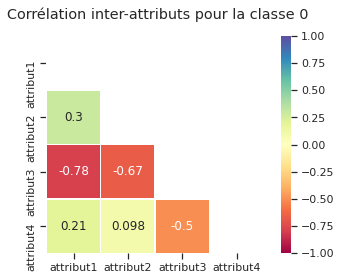

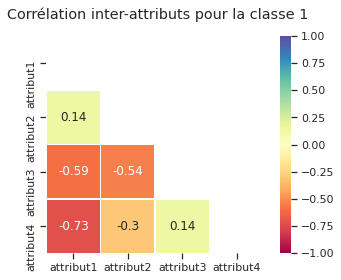

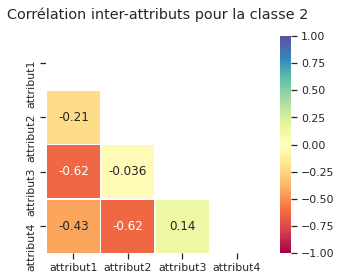

In [10]:
correlations = [corr_c0_df, corr_c1_df, corr_c2_df]
for _index, _corr in enumerate(correlations):
    mask = np.triu(np.ones_like(_corr, dtype=bool))
    plt.figure(_index)
    plt.suptitle("Corrélation inter-attributs pour la classe %i" %_index)
    sns.heatmap(_corr,  mask=mask, vmax=1, vmin=-1, center=0,
            square=True, cmap='Spectral', annot=True, linewidth=0.5)
    plt.show()

## (a)

Suite à la visualisation et l'analyse de corrélation de l'ensemble de données, nous constatons qu'il serait favorable de procéder à une analyse des composantes principales.

Effectivement, nous constatons que l'**attribut1** ainsi que l'**attribut3** semblent négativement corrélés peu importe la classe sous analyse.

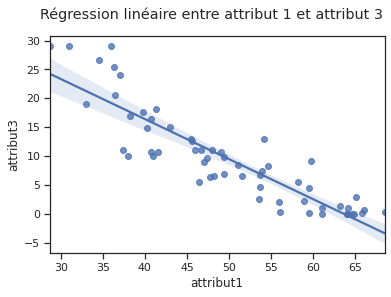

Nous constatons la corrélation négative entre l'attribut 1 et 3


In [11]:
sns.regplot(df.loc[:, 'attribut1'], df.loc[:, 'attribut3'])
plt.suptitle("Régression linéaire entre attribut 1 et attribut 3")
plt.show()
print("Nous constatons la corrélation négative entre l'attribut 1 et 3")

### Analyse ACP

In [12]:
pca_full = PCA(n_components=X.shape[1])
pca_full.fit(X)
X_pca_full = pca_full.transform(X)

print("PCA(4) explained variance: ", pca_full.explained_variance_ratio_, "which sum up to: ",
      np.round(pca_full.explained_variance_ratio_.sum()*100, 2), "%")

PCA(4) explained variance:  [0.8418103  0.08441998 0.06948166 0.00428806] which sum up to:  100.0 %


In [13]:
pca_full.explained_variance_ratio_[:2].sum()

0.9262302821121219

On constate que suite a une analyse des composantes principales, seulement trois variables expliquent plus de 99% de la variance et que l'utilisation de deux variables seulement explique près de 93% de la variance.

In [14]:
def distanceToCentroidErrors(features, target, classes, distance_fct=sdist.euclidean, VI="none"):
    """
    inputs
    ------
    features: numpy array
    target: numpy array
    classes: numpy array representing the unique classes
    distance_fct: distance function (Euclidean, Manhattan, Mahalanobis*)
    VI: string ("none", "full", "by_classes")
    
    outputs
    -------
    errors_df: pandas dataframe
    centroids_dict = dictionary
    """
    centroids_dict = {}
    VI_dict = {}
    for _classe in classes:
        target_mask = target == _classe
        features_masked = features[target_mask]
        centroid = features_masked.mean(axis=0)
        centroids_dict[_classe] = centroid

        if VI == "by_classes":
            # Apply the covariance only on the masked dataset.
            VI_dict[_classe] = np.linalg.inv(np.cov(features_masked, rowvar=False))
        elif VI == "full":
            # Apply the covariance on the entire dataset.
            VI_dict[_classe] = np.linalg.inv(np.cov(features, rowvar=False))
        
    centroid_targets = []
    for _feature in features:
        if VI == "none":
            centroid_targets.append(np.argmin([distance_fct(_feature, _centroid) for
                           _classe, _centroid in centroids_dict.items()]))
        else:
            centroid_targets.append(
                np.argmin([distance_fct(_feature, _centroid, VI_dict[_classe]) for
                           _classe, _centroid in centroids_dict.items()]))

    errors_df = pd.DataFrame({'actual_classes': target, 'reduction_classes': centroid_targets})
    errors_df['divergence'] = (errors_df['actual_classes'] != errors_df['reduction_classes']).astype(int)
    
    return errors_df, centroids_dict

## (b)

Suite à l'analyse des composantes principales, ainsi qu'à la visualisation de ceux-ci, nous avons décidé d'utiliser la transformation par 3CP pour les étapes suivantes.

Effectivement, nous obtenons une erreur de distance réelle plus faible en utilisant l'ensemble 3CP à celui 2CP.

# VISUALISATION PCA(2) ?!?

### 2CP Comparaison

In [15]:
pca_2 = PCA(n_components=2)
pca_2.fit(X)
X_pca_2 = pca_2.transform(X)
print("PCA(2) explained variance: ", pca_2.explained_variance_ratio_, "which sum up to: ",
      np.round(pca_2.explained_variance_ratio_.sum()*100, 2), "%")

errors_df_2CP, centroids_dict_2CP = distanceToCentroidErrors(X_pca_2, target, classes, distance_fct=sdist.euclidean)
errors_pct = np.round(errors_df_2CP['divergence'].sum() / errors_df_2CP.shape[0], 3)
print("2CP - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df_2CP['divergence'].sum(), errors_df_2CP.shape[0], errors_pct))

PCA(2) explained variance:  [0.8418103  0.08441998] which sum up to:  92.62 %
2CP - Il y a un total de 10 erreurs sur  59, soit: 0.169 %.


Text(0, 0.5, 'tsne axe 2')

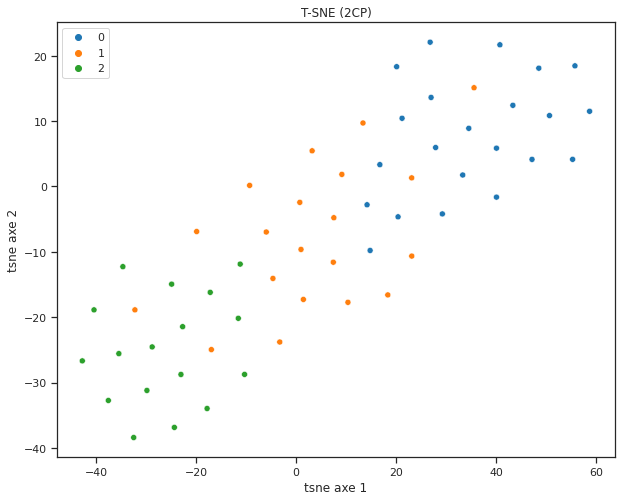

In [16]:
tsne = TSNE()
X_tsne_pca2 = tsne.fit_transform(X_pca_2)

fig, axes = plt.subplots(1, 1,figsize=(10,8))
sns.scatterplot(x=X_tsne_pca2[:,0], y=X_tsne_pca2[:,1], hue=target, palette='tab10')
axes.set_title('T-SNE (2CP)')
axes.set_xlabel("tsne axe 1")
axes.set_ylabel("tsne axe 2")

### 3CP Comparaison

In [17]:
pca_3 = PCA(n_components=3)
pca_3.fit(X)
X_pca_3 = pca_3.transform(X)
print("PCA(3) explained variance: ", pca_3.explained_variance_ratio_, "which sum up to: ",
      np.round(pca_3.explained_variance_ratio_.sum()*100, 2), "%")

errors_df_3CP, centroids_dict_3CP = distanceToCentroidErrors(X_pca_3, target, classes, distance_fct=sdist.euclidean)
errors_pct = np.round(errors_df_3CP['divergence'].sum() / errors_df_3CP.shape[0], 3)
print("3CP - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df_3CP['divergence'].sum(), errors_df_3CP.shape[0], errors_pct))


PCA(3) explained variance:  [0.8418103  0.08441998 0.06948166] which sum up to:  99.57 %
3CP - Il y a un total de 9 erreurs sur  59, soit: 0.153 %.


Text(0, 0.5, 'tsne axe 2')

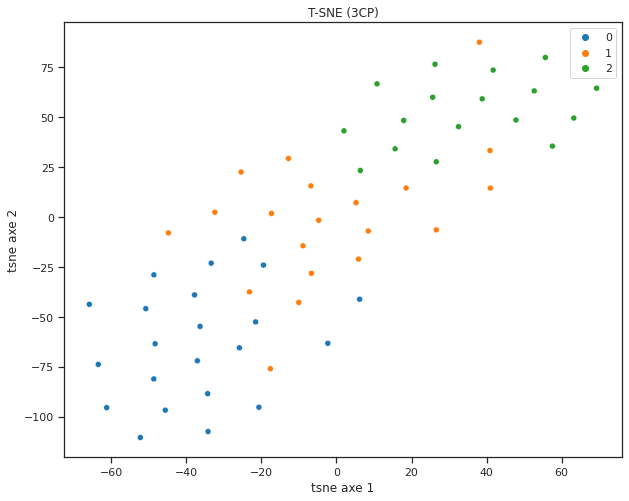

In [18]:
tsne = TSNE()
X_tsne_pca3 = tsne.fit_transform(X_pca_3)

fig, axes = plt.subplots(1, 1,figsize=(10,8))
sns.scatterplot(x=X_tsne_pca3[:,0], y=X_tsne_pca3[:,1], hue=target, palette='tab10')
axes.set_title('T-SNE (3CP)')
axes.set_xlabel("tsne axe 1")
axes.set_ylabel("tsne axe 2")

#### Graphiques des erreurs de classification

Nous utiliserons la distribution 3CP pour cette représentation

Text(0.5, 0.92, 'Erreurs de classification en utilisant la distance euclidienne - projection sur PC1 & PC3')

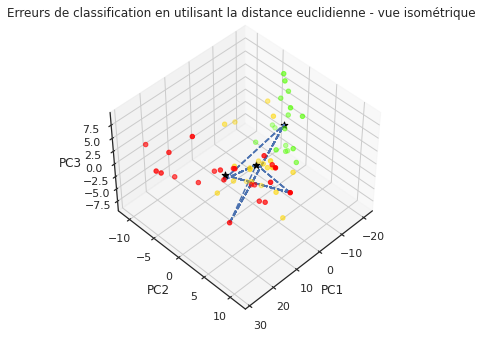

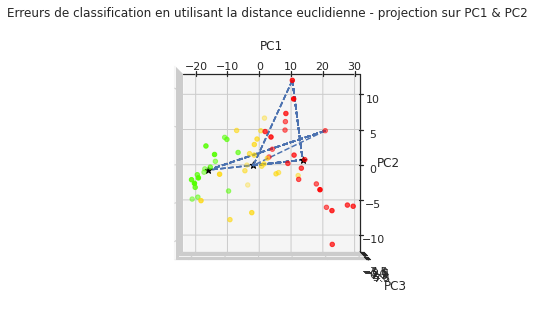

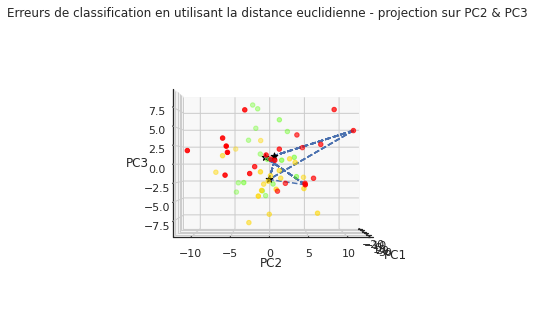

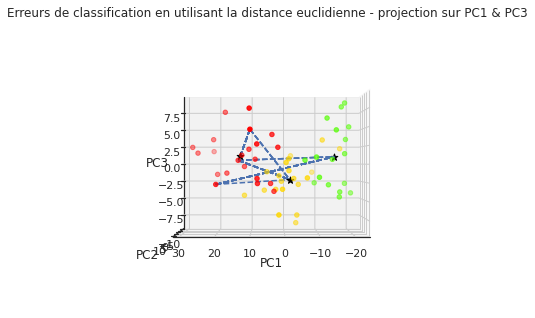

In [19]:
def PlotPC3D(X, Y, Z, elevation:int, azimut:int, c_dict:dict, error_vector:pd.DataFrame):
    fig = plt.figure()
    ax = Axes3D(fig, elev=elevation, azim=azimut)

    #Here we plot the data points for each class
    ax.scatter(X, Y, Z, c=target, cmap='prism')

    # Here we plot the centroids of each class in the 3D Graphs
    ax.scatter(xs=c_dict[0][0], ys=c_dict[0][1], zs=c_dict[0][2], marker='*', c='black',
               depthshade=True, s = 50)
    ax.scatter(xs=c_dict[1][0], ys=c_dict[1][1], zs=c_dict[1][2], marker='*', c='black',
               depthshade=True, s = 50)
    ax.scatter(xs=c_dict[2][0], ys=c_dict[2][1], zs=c_dict[2][2], marker='*', c='black',
               depthshade=True, s = 50)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    centroids = np.array([c_dict[0], c_dict[1], c_dict[2]])

    # Here we plot the dote-lined red error vectors in the 3D Graphs
    for index, err in error_vector.iterrows():
        err_vec_xs = np.array([X_pca_3[int(err[0]), 0], centroids[int(err[1]), 0]])
        err_vec_ys = np.array([X_pca_3[int(err[0]), 1], centroids[int(err[1]), 1]])
        err_vec_zs = np.array([X_pca_3[int(err[0]), 2], centroids[int(err[1]), 2]])
        ax.plot(err_vec_xs, err_vec_ys, err_vec_zs, 'b--')

    return fig, ax

# Plot some error vectors graphs
_, ax1 = PlotPC3D(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], elevation=45, azimut=45,
                  c_dict=centroids_dict_3CP, error_vector=errors_df_3CP)
_, ax2 = PlotPC3D(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], elevation=90, azimut=270,
                  c_dict=centroids_dict_3CP, error_vector=errors_df_3CP)
_, ax3 = PlotPC3D(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], elevation=0, azimut=0,
                  c_dict=centroids_dict_3CP, error_vector=errors_df_3CP)
_, ax4 = PlotPC3D(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], elevation=0, azimut=90,
                  c_dict=centroids_dict_3CP, error_vector=errors_df_3CP)

ax1.set_title('Erreurs de classification en utilisant la distance euclidienne - vue isométrique')
ax2.set_title('Erreurs de classification en utilisant la distance euclidienne - projection sur PC1 & PC2')
ax3.set_title('Erreurs de classification en utilisant la distance euclidienne - projection sur PC2 & PC3')
ax4.set_title('Erreurs de classification en utilisant la distance euclidienne - projection sur PC1 & PC3')

# 2. Mesure de distance:

## (a)
Suite à l'étape 1, il a été décidé d'utiliser l'ensemble ayant subit une transformation par ACP à trois (3) composantes principales.

In [20]:
X_pca = X_pca_3

### Distance Manhattan - 3CP

In [21]:
errors_df, _ = distanceToCentroidErrors(X_pca, target, classes, distance_fct=sdist.cityblock)

errors_pct = np.round(errors_df['divergence'].sum() / errors_df.shape[0], 3)
print("Manhanttan - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df['divergence'].sum(), errors_df.shape[0], errors_pct))

Manhanttan - Il y a un total de 10 erreurs sur  59, soit: 0.169 %.


### Distance Euclidienne - 3CP

In [22]:
errors_df, _ = distanceToCentroidErrors(X_pca, target, classes, distance_fct=sdist.euclidean)

errors_pct = np.round(errors_df['divergence'].sum() / errors_df.shape[0], 3)
print("Euclidean - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df['divergence'].sum(), errors_df.shape[0], errors_pct))


Euclidean - Il y a un total de 9 erreurs sur  59, soit: 0.153 %.


### Distance Mahalanobis

Bien qu'il ne soit pas nécessaire d'appliquer une transformation par ACP lorsque la distance de Mahalanobis est utilisée, nous avons tout de même décidé d'utilisé l'ensemble transformé (3CP) pour fin de cohérence.

Il n'est pas necessaire d'appliquer une analyse de reduction de dimensions dans le cas de la distance de Mahalanobis. Nous pouvons donc utiliser l'ensemble de depart.

3:40 Cours du mercredi


Elle se ramene a des attributs orthogonaux
prends la distribution des points pour calculer la covariance entre les differents attributs
la ou il y a le plus de varriance, elle va donner moins de forces au distances

6:38 ** 

Typiquement, on 


In [23]:
errors_df, _ = distanceToCentroidErrors(X_pca, target, classes, 
                                        distance_fct=sdist.mahalanobis, VI="full")

errors_pct = np.round(errors_df['divergence'].sum() / errors_df.shape[0], 3)
print("Mahalanobis (Inverted Matrix from full dataset) - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df['divergence'].sum(), errors_df.shape[0], errors_pct))

Mahalanobis (Inverted Matrix from full dataset) - Il y a un total de 12 erreurs sur  59, soit: 0.203 %.


## (b)

Nous constatons que l'utilisation de la matrice de covariance par classe permet de réduire l'erreur d'association. De plus, cette option nous permet d'obtenir l'erreur la plus faible des différentes mesures de distances.

C'est d'ailleurs en employant cette option que nous procéderons aux prochaines étapes.

In [24]:
errors_df, centroids_dict = distanceToCentroidErrors(X_pca, target, classes,
                                                     distance_fct=sdist.mahalanobis, VI="by_classes")

errors_pct = np.round(errors_df['divergence'].sum() / errors_df.shape[0], 3)
print("Mahalanobis (Inverted Matrix by classes) - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df['divergence'].sum(), errors_df.shape[0], errors_pct))

Mahalanobis (Inverted Matrix by classes) - Il y a un total de 7 erreurs sur  59, soit: 0.119 %.


# 3. Choix du modele de classification

## (a)

Tel que mentionné, nous utiliserons l'ensemble ayant subit une transformation par ACP à trois (3) composantes principales ainsi que la distance de Mahalanobis ajusté de sorte que la matrice de covariance utilisée soit propre à la classe du centroïde de référence.

In [25]:
X_pca = X_pca_3

### K-Nearest Neighbors Classifier

In [26]:
def get_neighbors_knn(train, label, test_row, k_neighbors, VI_for_class):
    distances = list()
    for i, train_row in enumerate(train):
        dist = sdist.mahalanobis(train_row, test_row, VI_for_class.get(label[i]))
        distances.append((label[i], dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors_label = list()
    for i in range(k_neighbors):
        neighbors_label.append(distances[i][0])
    return neighbors_label

3CP ne devrait pas etre sur l'ensemble des donnees ?? 

In [27]:
transformed_3CP_c = {}

pca_knn = PCA(n_components=3)
centered_X_knn = X - np.mean(X)
pca_knn.fit(centered_X_knn, target)  ## ? pourquoi utiliser centered_X_knn pour fit puis ensuite transforme sur X ?

pca_3CP_c = []
centroids_3CP = {}
transformed_3CP_c = {}

for y_i in classes:
    transformed_3CP_c[y_i] = pca_knn.transform(X.loc[target == y_i])  # transform... 
    centroids_3CP[y_i] = transformed_3CP_c[y_i].mean(axis=0)   
    pca_3CP_c.extend(transformed_3CP_c[y_i])
tranformed_c = transformed_3CP_c

# Inverted covariance by classes
VI_for_class = {}
for y_i in classes:
    VI_for_class[y_i] = np.linalg.inv(np.cov(tranformed_c[y_i], rowvar=False))

In [28]:
k = 5
nb_iter = 100
scores = 0
for it in range(nb_iter):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.2, stratify=target)
    errors_knn = 0
    for i, x_i_test in enumerate(X_test):
        neighbors_label = get_neighbors_knn(train=X_train, label=y_train, test_row=x_i_test,
                                            k_neighbors=k, VI_for_class=VI_for_class)
        
        prediction = max(neighbors_label, key=neighbors_label.count)
        if prediction != y_test[i]: errors_knn += 1
    scores += 1 - errors_knn/len(X_test)
print(f"Justesse test {scores/nb_iter:.3%}")

Justesse test 81.250%


### Nearest Centroid

In [29]:
nb_iter = 500
scores = 0

centroids_x_train_mean, cov_matrix_x_train_mean = [0, 0, 0], [0, 0, 0]
for it in range(nb_iter):
    errors_nc = 0
    X_train, X_test, y_train, y_test = train_test_split(X.values, target, test_size=0.2, stratify=target)
    centroids_x_train, cov_matrix_x_train = {}, {}
    for y_i in classes:
        xx = X_train[y_train == y_i]
        centroids_x_train[y_i] = np.mean(xx, axis=0)  # centroid by classes
        cov_matrix_x_train[y_i] = np.linalg.inv(np.cov(xx, rowvar=False))  # inverted covariance by classes

        centroids_x_train_mean[y_i] += centroids_x_train[y_i]    ## - STOP - Je ne comprends pas ici 
        cov_matrix_x_train_mean[y_i] += cov_matrix_x_train[y_i]

    # Compute errors on the test set using the training centroids and their associated inverted covariance matrix.
    for i, x_i_test in enumerate(X_test):
        centroid_label = np.argmin([sdist.mahalanobis(x_i_test, centroids_x_train.get(j), cov_matrix_x_train.get(j))
                for j in centroids_x_train.keys()])

        if centroid_label != y_test[i]:
            errors_nc += 1
    
    scores += 1 - errors_nc/len(X_test)

print(f"Justesse test {scores/nb_iter:.3%}")

# On garde en mémoire les centroides et les matrices de covariance associées utiles pour la prédiction
centroids_x_train_mean = np.divide(centroids_x_train_mean, nb_iter)  # prends le centre des centres ... 
cov_matrix_x_train_mean = np.divide(cov_matrix_x_train_mean, nb_iter)  # pas sur qu'on puisse additionner des inverses covariance

Justesse test 87.550%


## (b)

In [30]:
"""
The next section has been adapted from the code available on the Sci-Kit learn web site:
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py

Start of adapted section
"""

estimators = {cov_type: GaussianMixture(n_components=len(classes),
              covariance_type=cov_type, random_state=0)
              for cov_type in ['spherical', 'diag', 'full', 'tied']}
cov_type = ['full', 'tied', 'diag', 'spherical']
scores_train, scores_test = np.zeros(len(cov_type)), np.zeros(len(cov_type))

nb_iter = 100
for it in range(nb_iter):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.2, stratify=target)
    centroids_x_train_gaussian =[np.mean(X_train[y_train == _c], axis=0) for _c in classes]

    for i, ct in enumerate(cov_type):
        estimators[ct].set_params(**{'means_init':centroids_x_train_gaussian})
        estimators[ct].fit(X_train, y=y_train)

        y_train_pred = estimators[ct].predict(X_train)
        scores_train[i] += np.mean(y_train_pred == y_train)
        y_test_pred = estimators[ct].predict(X_test)
        scores_test[i] += np.mean(y_test_pred == y_test)

print("Score de justesse en fonction du type de covariance:")
for i, ct in enumerate(cov_type):
    print(f"{ct} :  entraînement: {scores_train[i]/nb_iter:.3%} - test: {scores_test[i]/nb_iter:.3%}")

Score de justesse en fonction du type de covariance:
full :  entraînement: 76.596% - test: 73.000%
tied :  entraînement: 77.043% - test: 72.833%
diag :  entraînement: 75.830% - test: 73.250%
spherical :  entraînement: 83.106% - test: 80.083%


# 4. Application:

La méthode ayant obtenu le résultat de justesse le plus élevé est celle du plus proche centroïde. Suite à la transformation 3CP de la nouvelle observation, la méthode retenue prédit une classification à la classe 1.

In [31]:
observation = np.array([[52.1, 23.0, 6.1, 16.5]])
pca_observation = pca_3.transform(observation)

centroid_prediction = np.argmin([sdist.mahalanobis(observation, centroids_x_train_mean[_c],
                                                   cov_matrix_x_train_mean[_c]) for _c in classes])
print("Centroid Classifier Prediction Class: ", centroid_prediction)

Centroid Classifier Prediction Class:  1


In [32]:
observation = np.array([[52.1, 23.0, 6.1, 16.5]])
pca_observation = pca_3.transform(observation)

neighbors_label = get_neighbors_knn(train=X_pca_3, label=target, test_row=pca_observation,
                                    k_neighbors=5, VI_for_class=VI_for_class)
KNN_prediction = max(neighbors_label, key=neighbors_label.count)
print("KNN Classifier Prediction Classe: ", KNN_prediction)


centroid_prediction = np.argmin([sdist.mahalanobis(observation, centroids_x_train_mean[_c],
                                                   cov_matrix_x_train_mean[_c]) for _c in classes])
print("Centroid Classifier Prediction Classe: ", centroid_prediction)


print("Spherical GMM Prediction Classe: ", estimators['spherical'].predict(pca_observation)[0])
print("Diagonal GMM Prediction Classe: ", estimators['diag'].predict(pca_observation)[0])
print("Full GMM Prediction Classe: ", estimators['full'].predict(pca_observation)[0])
print("Tied GMM Prediction Classe: ", estimators['tied'].predict(pca_observation)[0])


KNN Classifier Prediction Classe:  1
Centroid Classifier Prediction Classe:  1
Spherical GMM Prediction Classe:  1
Diagonal GMM Prediction Classe:  1
Full GMM Prediction Classe:  1
Tied GMM Prediction Classe:  1
